In [40]:
!pip install -q scanpy anndata igraph leidenalg

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import igraph
import leidenalg
import scipy
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/content/drive/MyDrive/anndata.h5ad')

In [4]:
def BasicScanpyPreprocessing(adata, n_top_genes = 2000, n_neighbors=10, n_pcs = 40, random_state = 20):
  sc.pp.normalize_total(adata, target_sum = 1e4)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, n_top_genes = n_top_genes, flavor = 'seurat')
  #sc.pp.scale(adata, max_value=10)
  sc.tl.pca(adata, svd_solver = 'arpack')
  sc.pp.neighbors(adata, n_neighbors = n_neighbors, n_pcs = n_pcs, random_state = random_state)
  sc.tl.umap(adata, random_state = random_state)
  sc.tl.tsne(adata, random_state = random_state)
  sc.tl.leiden(adata, random_state = random_state)
  return adata

In [5]:
adata = BasicScanpyPreprocessing(adata)

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
<ipython-input-4-0b290b09c639>:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, random_state = random_state)


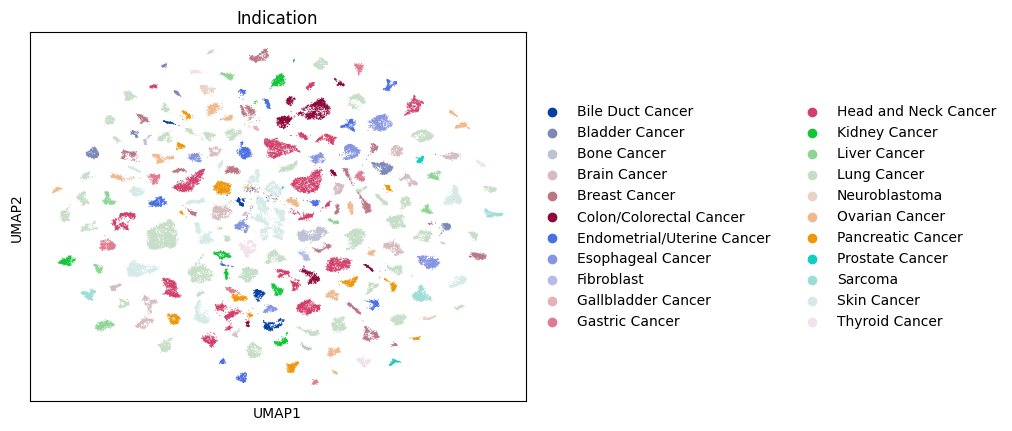

In [6]:
sc.pl.umap(adata, color = ['Indication'])

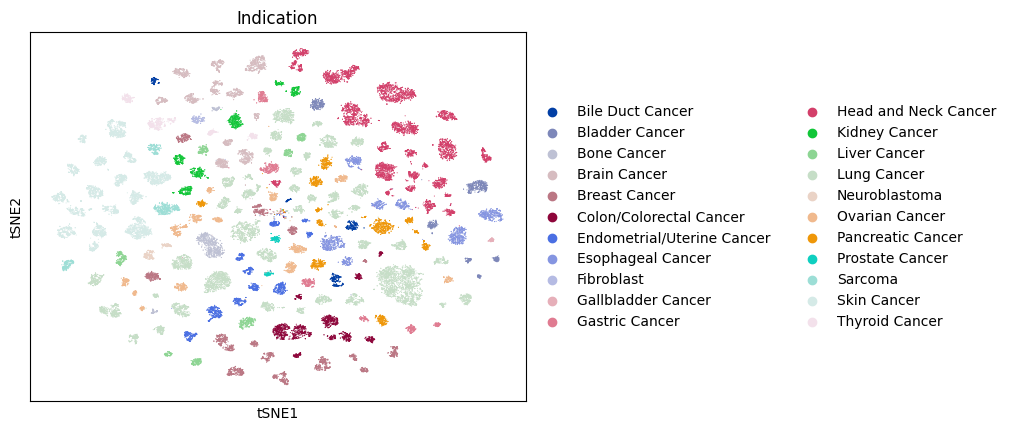

In [7]:
sc.pl.tsne(adata, color = ['Indication'])

In [8]:
adata.layers['counts'] = adata.X.copy()
adata.layers['log2_counts'] = scipy.sparse.csr_matrix(np.log2(adata.layers['counts'].toarray()+1))

In [9]:
def ExploreCellLines(gene, indication = 'Indication'):
  if(indication != 'Indication'):
    adata_indication = adata[adata.obs.Indication==indication].copy()
    df = sc.get.obs_df(adata_indication, keys = ['ERBB2', 'VEGFA', 'VEGFB'], layer = 'log2_counts')
    df['CellLine'] = adata_indication.obs['CellLine']
    sns.boxplot(data = df, x = 'CellLine', y = gene, hue = 'CellLine', showfliers = False)
    sns.stripplot(data = df, x = 'CellLine', y = gene, color = 'black', size = 1, jitter = True)
    plt.xticks(rotation = 90)
  else:
    df = sc.get.obs_df(adata, keys = ['ERBB2', 'VEGFA', 'VEGFB'], layer = 'log2_counts')
    df['Indication'] = adata.obs['Indication']
    sns.boxplot(data = df, x = 'Indication', y = gene, hue = 'Indication', showfliers = False)
    sns.stripplot(data = df, x = 'Indication', y = gene, color = 'black', size = 0.5, jitter = True)
    plt.xticks(rotation = 90)

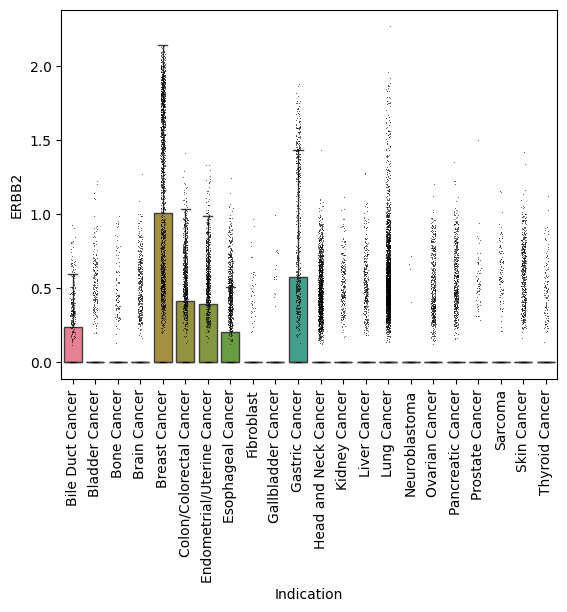

In [10]:
ExploreCellLines('ERBB2')

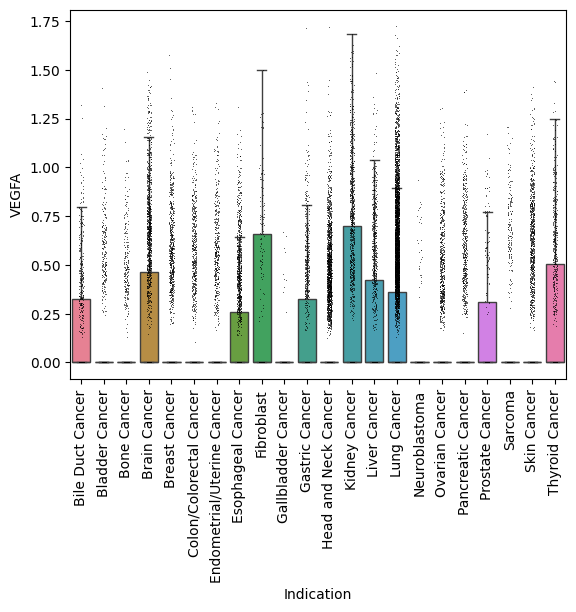

In [11]:
ExploreCellLines('VEGFA')

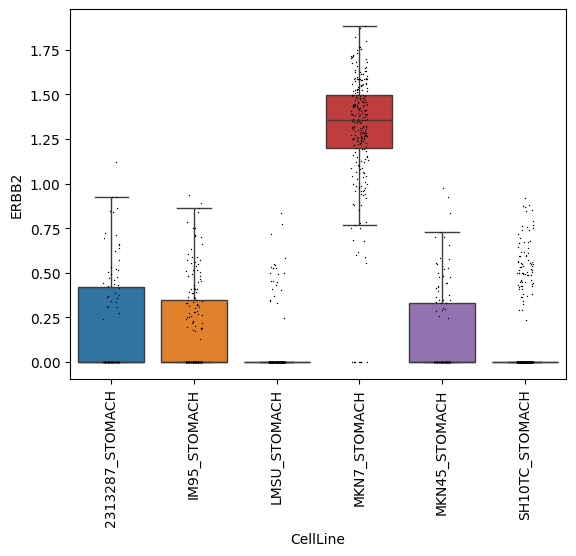

In [12]:
ExploreCellLines('ERBB2', 'Gastric Cancer')

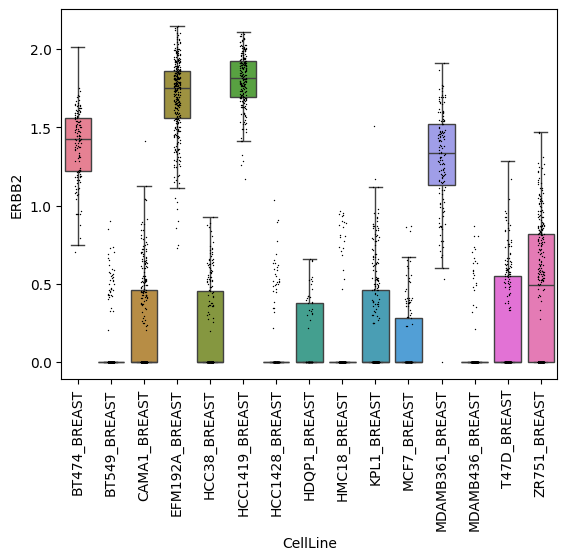

In [13]:
ExploreCellLines('ERBB2', 'Breast Cancer')

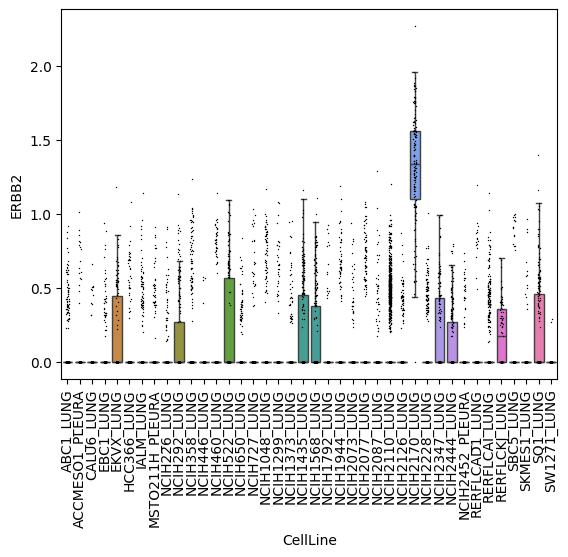

In [14]:
ExploreCellLines('ERBB2', 'Lung Cancer')

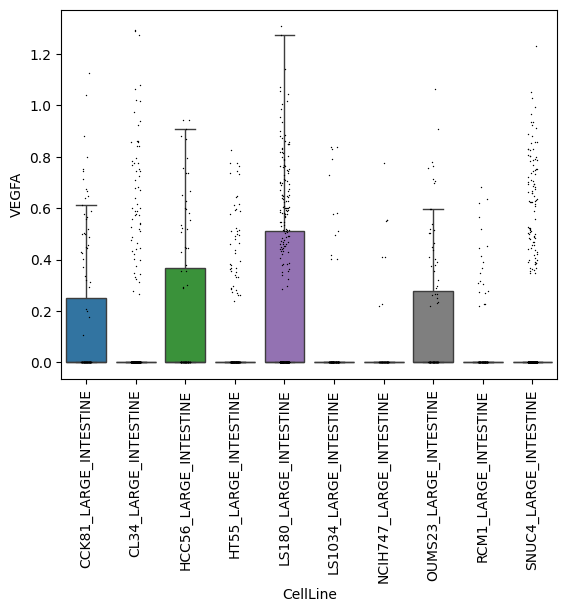

In [15]:
ExploreCellLines('VEGFA', 'Colon/Colorectal Cancer')

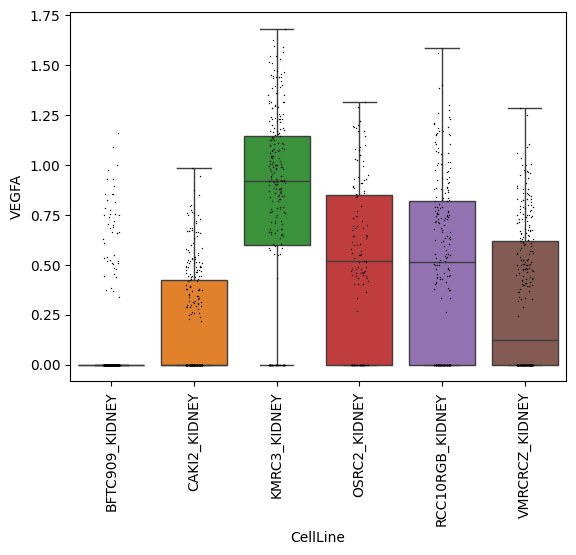

In [16]:
ExploreCellLines('VEGFA', 'Kidney Cancer')

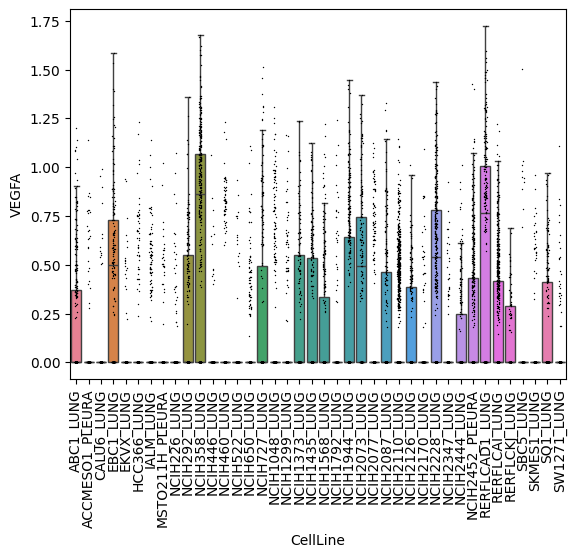

In [17]:
ExploreCellLines('VEGFA', 'Lung Cancer')

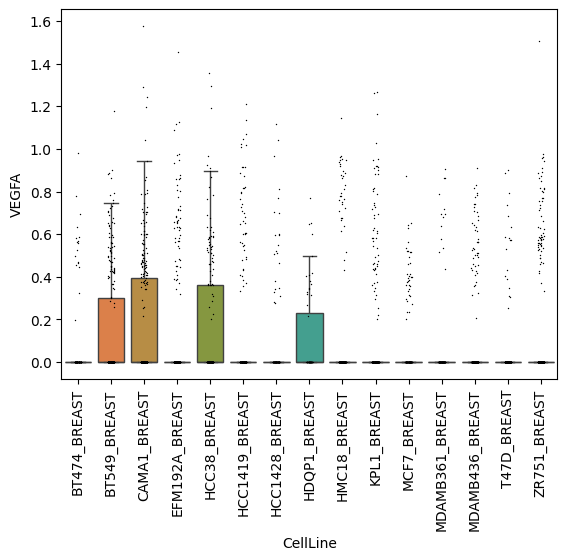

In [18]:
ExploreCellLines('VEGFA', 'Breast Cancer')

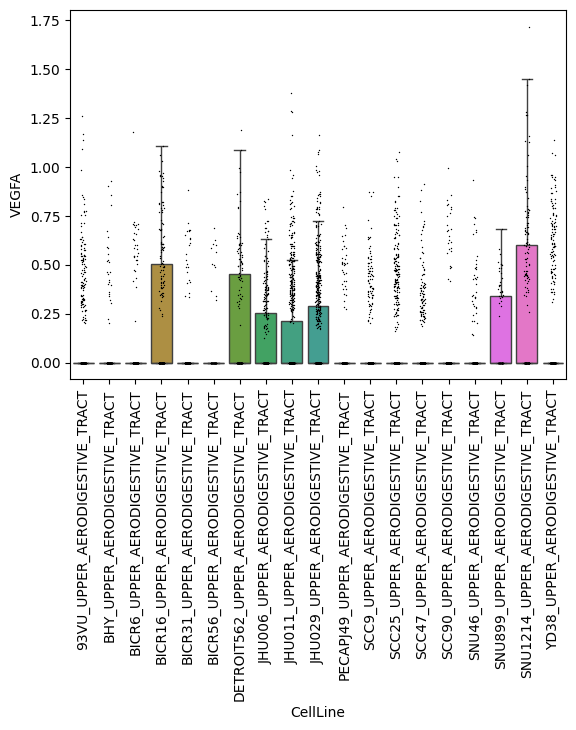

In [19]:
ExploreCellLines('VEGFA', 'Head and Neck Cancer')

In [20]:
adata_lung = adata[adata.obs.Indication=='Lung Cancer'].copy()
df_lung = sc.get.obs_df(adata_lung, keys = ['ERBB2', 'VEGFA', 'VEGFB'], layer = 'log2_counts')
df_lung['CellLine'] = adata_lung.obs['CellLine']
df_lung.head()

,ERBB2,VEGFA,VEGFB,CellLine
AAACCTGAGACATAAC-1-18,0.000000,0.381903,0.618537,NCIH2126_LUNG
AAACCTGCATGGATGG-1-18,0.000000,0.000000,0.000000,NCIH446_LUNG
AAACGGGGTTTAGGAA-1-18,0.000000,0.000000,0.000000,NCIH2452_PLEURA
AAAGATGGTGCGGTAA-1-18,0.687221,0.000000,0.000000,NCIH2452_PLEURA
AAATGCCGTCACCTAA-1-18,0.000000,0.000000,0.000000,NCIH446_LUNG


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

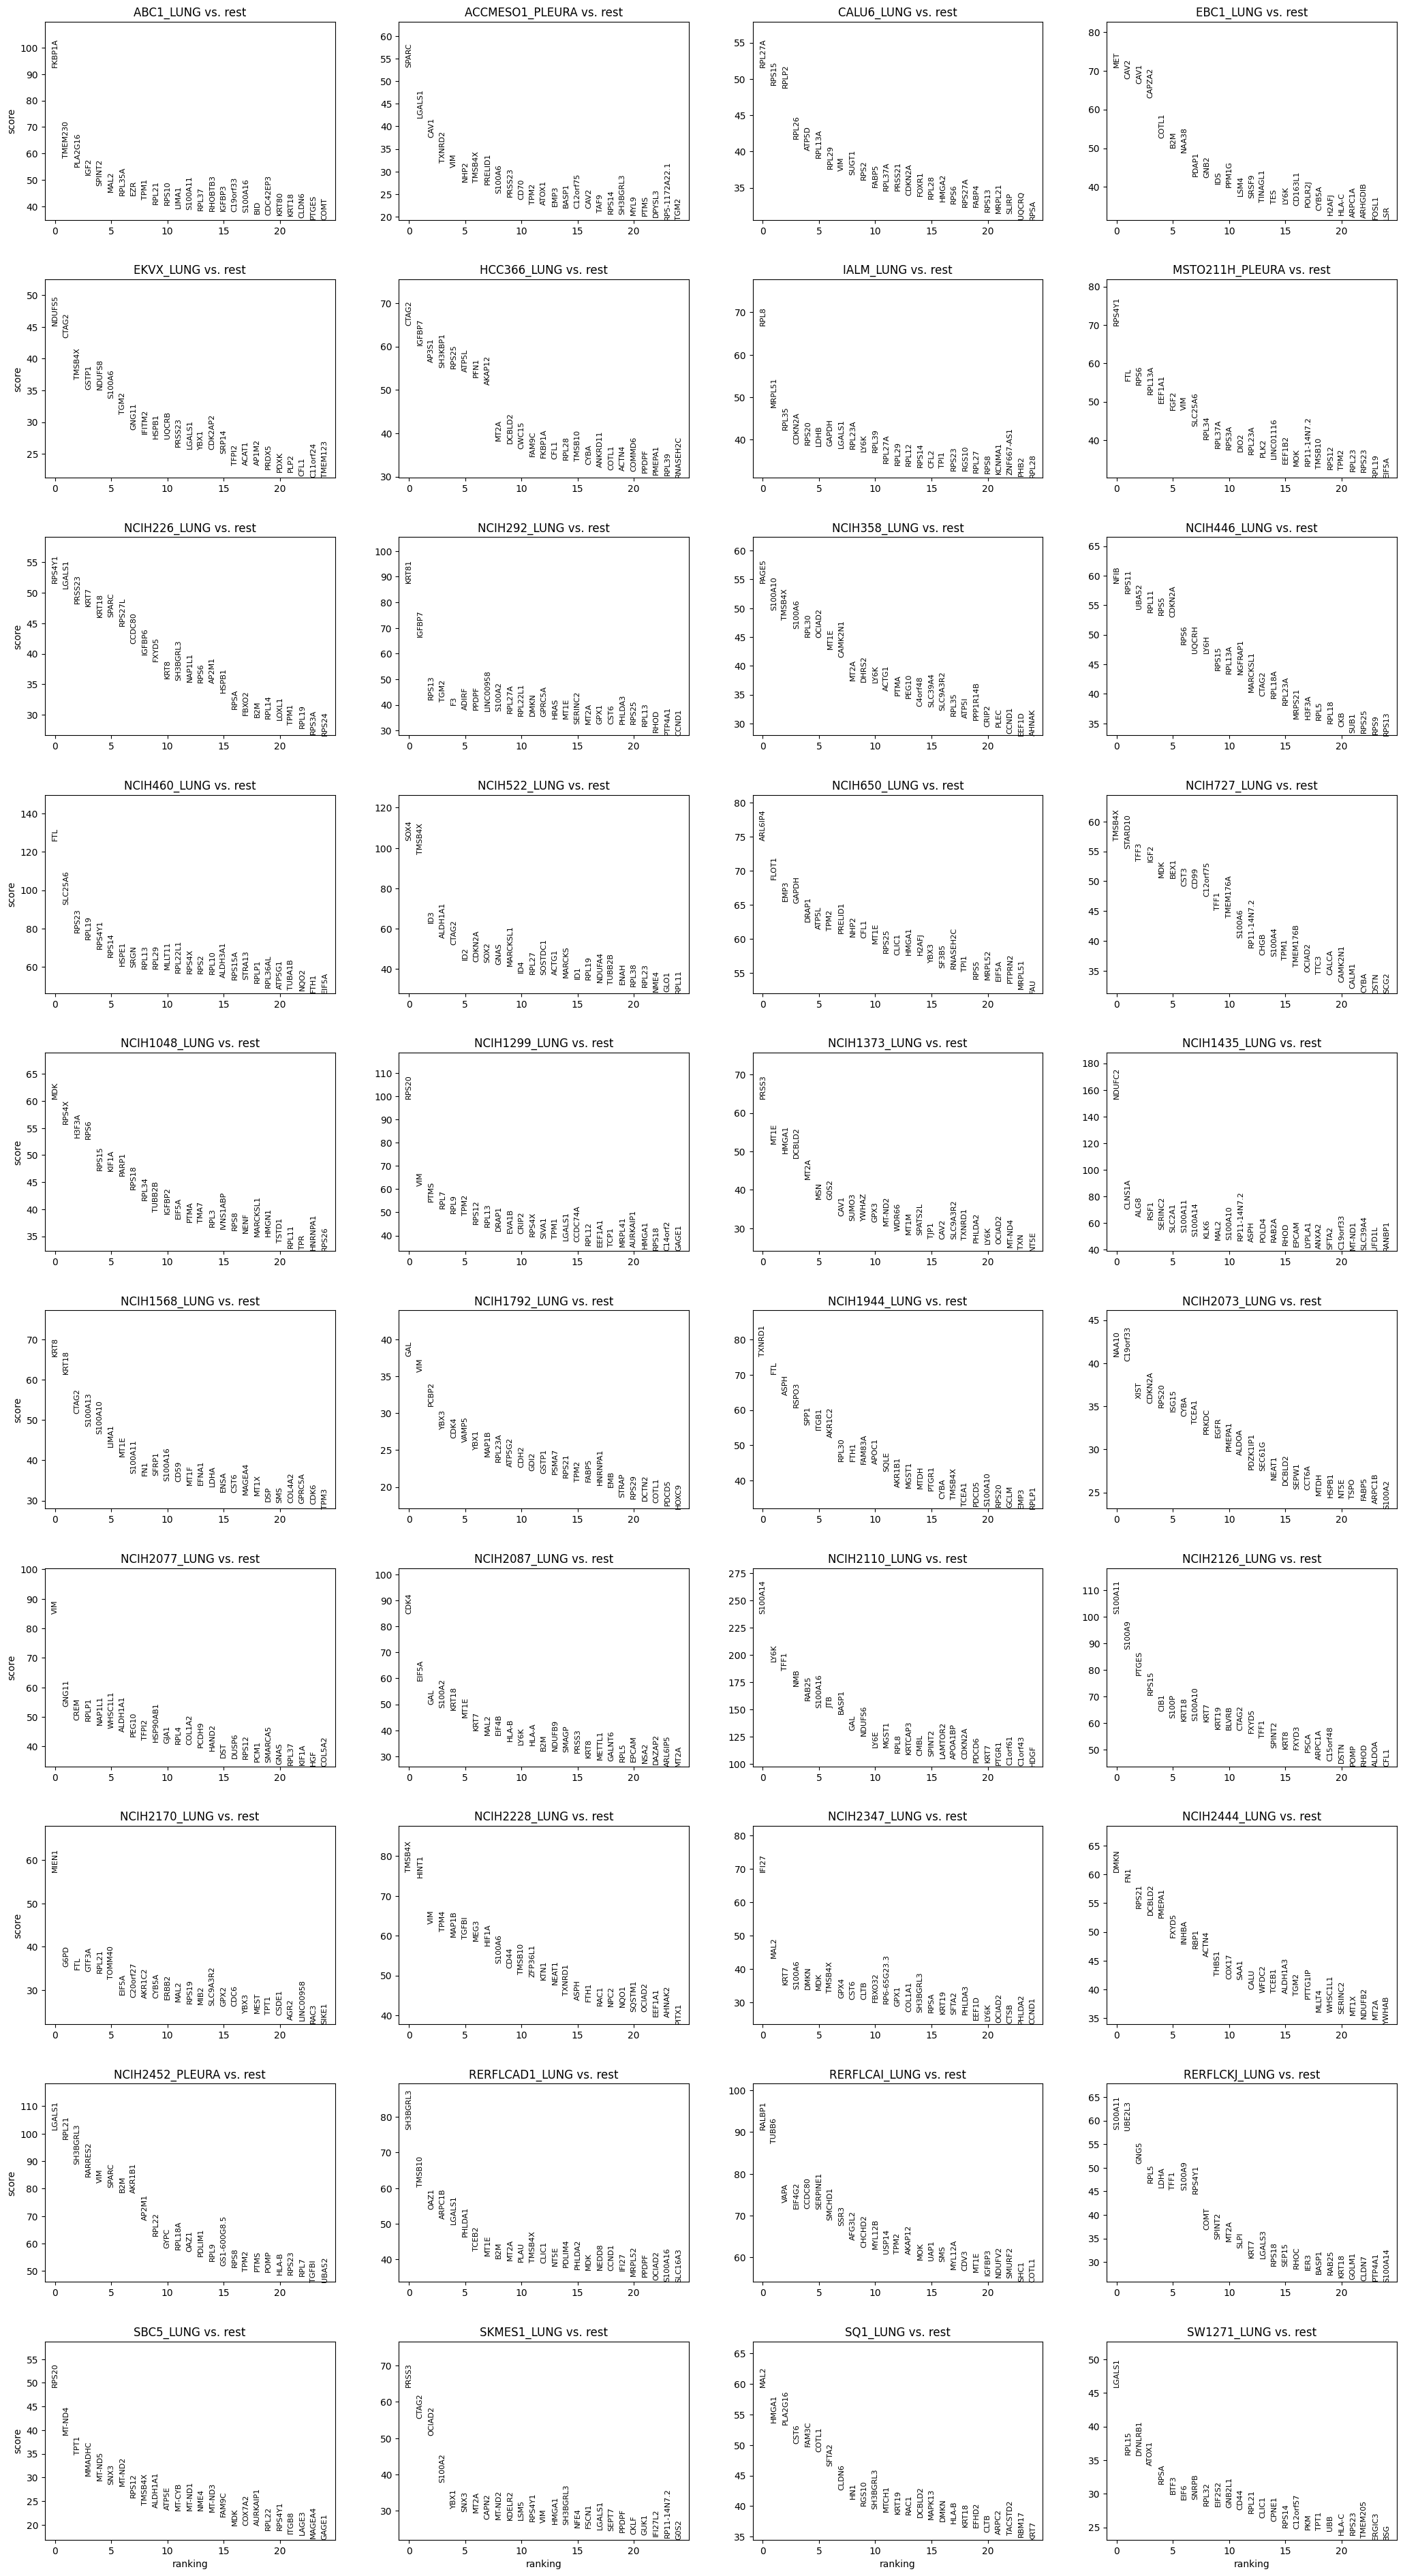

In [21]:
# Differential gene expression analysis
sc.tl.rank_genes_groups(adata_lung, groupby = 'CellLine', method = 't-test', key_added = 't_test')
sc.pl.rank_genes_groups(adata_lung, groupby = 'CellLine', n_genes = 25, sharey = False, key = 't_test')

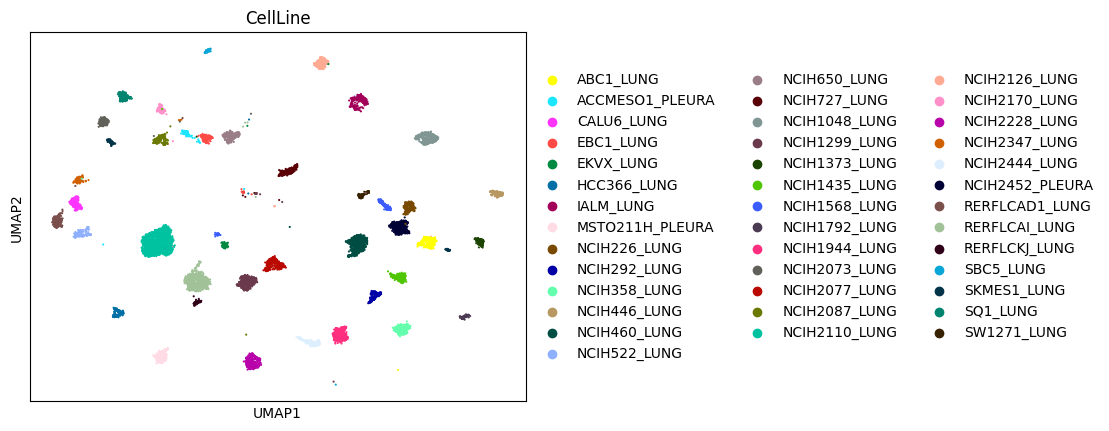

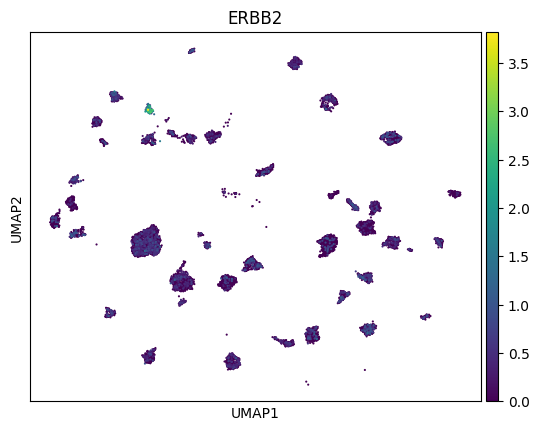

In [22]:
sc.pl.umap(adata_lung, color = ['CellLine'])
sc.pl.umap(adata_lung, color = ['ERBB2'])

In [23]:
df_lung_target = df_lung[df_lung['CellLine']=='NCIH2170_LUNG'].copy()
df_lung_others = df_lung[df_lung['CellLine']!='NCIH2170_LUNG'].copy()

In [24]:
t_stat, p_value = stats.ttest_ind(df_lung_target['ERBB2'], df_lung_others['ERBB2'], equal_var = False)
print(f"T statistic: {t_stat} \n P value: {p_value}")
f_stat, p_value = stats.f_oneway(df_lung_target['ERBB2'], df_lung_others['ERBB2'])
print(f"F statistic: {f_stat} \n P value: {p_value}")

T statistic: 38.66725312879398 
 P value: 2.551458288533391e-77
F statistic: 4005.561594678734 
 P value: 0.0


In [25]:
tukey_result = pairwise_tukeyhsd(endog = df_lung['ERBB2'], groups = df_lung['CellLine'], alpha = 0.05)
print(tukey_result)

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
      ABC1_LUNG ACCMESO1_PLEURA  -0.0311    1.0 -0.1154  0.0533  False
      ABC1_LUNG      CALU6_LUNG  -0.0843 0.0051 -0.1576 -0.0109   True
      ABC1_LUNG       EBC1_LUNG  -0.0076    1.0 -0.0883  0.0731  False
      ABC1_LUNG       EKVX_LUNG   0.0688  0.464 -0.0185  0.1562  False
      ABC1_LUNG     HCC366_LUNG   0.0004    1.0 -0.0783  0.0791  False
      ABC1_LUNG       IALM_LUNG  -0.0042    1.0 -0.0734  0.0651  False
      ABC1_LUNG MSTO211H_PLEURA  -0.0343 0.9985  -0.105  0.0363  False
      ABC1_LUNG   NCIH1048_LUNG   0.0027    1.0 -0.0631  0.0685  False
      ABC1_LUNG   NCIH1299_LUNG  -0.0646 0.0285 -0.1267 -0.0025   True
      ABC1_LUNG   NCIH1373_LUNG   0.0141    1.0   -0.07  0.0981  False
      ABC1_LUNG   NCIH1435_LUNG   0.0825 0.0064  0.0098  0.1551   True
      

In [26]:
adata_hnscc = adata[adata.obs.Indication=='Head and Neck Cancer'].copy()
df_hnscc = sc.get.obs_df(adata_hnscc, keys = ['ERBB2', 'VEGFA', 'VEGFB'], layer = 'log2_counts')
df_hnscc['CellLine'] = adata_hnscc.obs['CellLine']
df_hnscc.head()

,ERBB2,VEGFA,VEGFB,CellLine
AAAGCAACACTTGGAT-1-18,0.0,0.000000,0.356013,SNU899_UPPER_AERODIGESTIVE_TRACT
AAATGCCAGCCGCCTA-1-18,0.0,0.000000,0.000000,SNU899_UPPER_AERODIGESTIVE_TRACT
ACCAGTACAGTAACGG-1-18,0.0,0.240139,0.416178,SNU899_UPPER_AERODIGESTIVE_TRACT
ACGAGGATCGGCTACG-1-18,0.0,0.359596,0.000000,SNU899_UPPER_AERODIGESTIVE_TRACT
AGCCTAAAGATCGATA-1-18,0.0,0.367599,0.000000,SNU899_UPPER_AERODIGESTIVE_TRACT


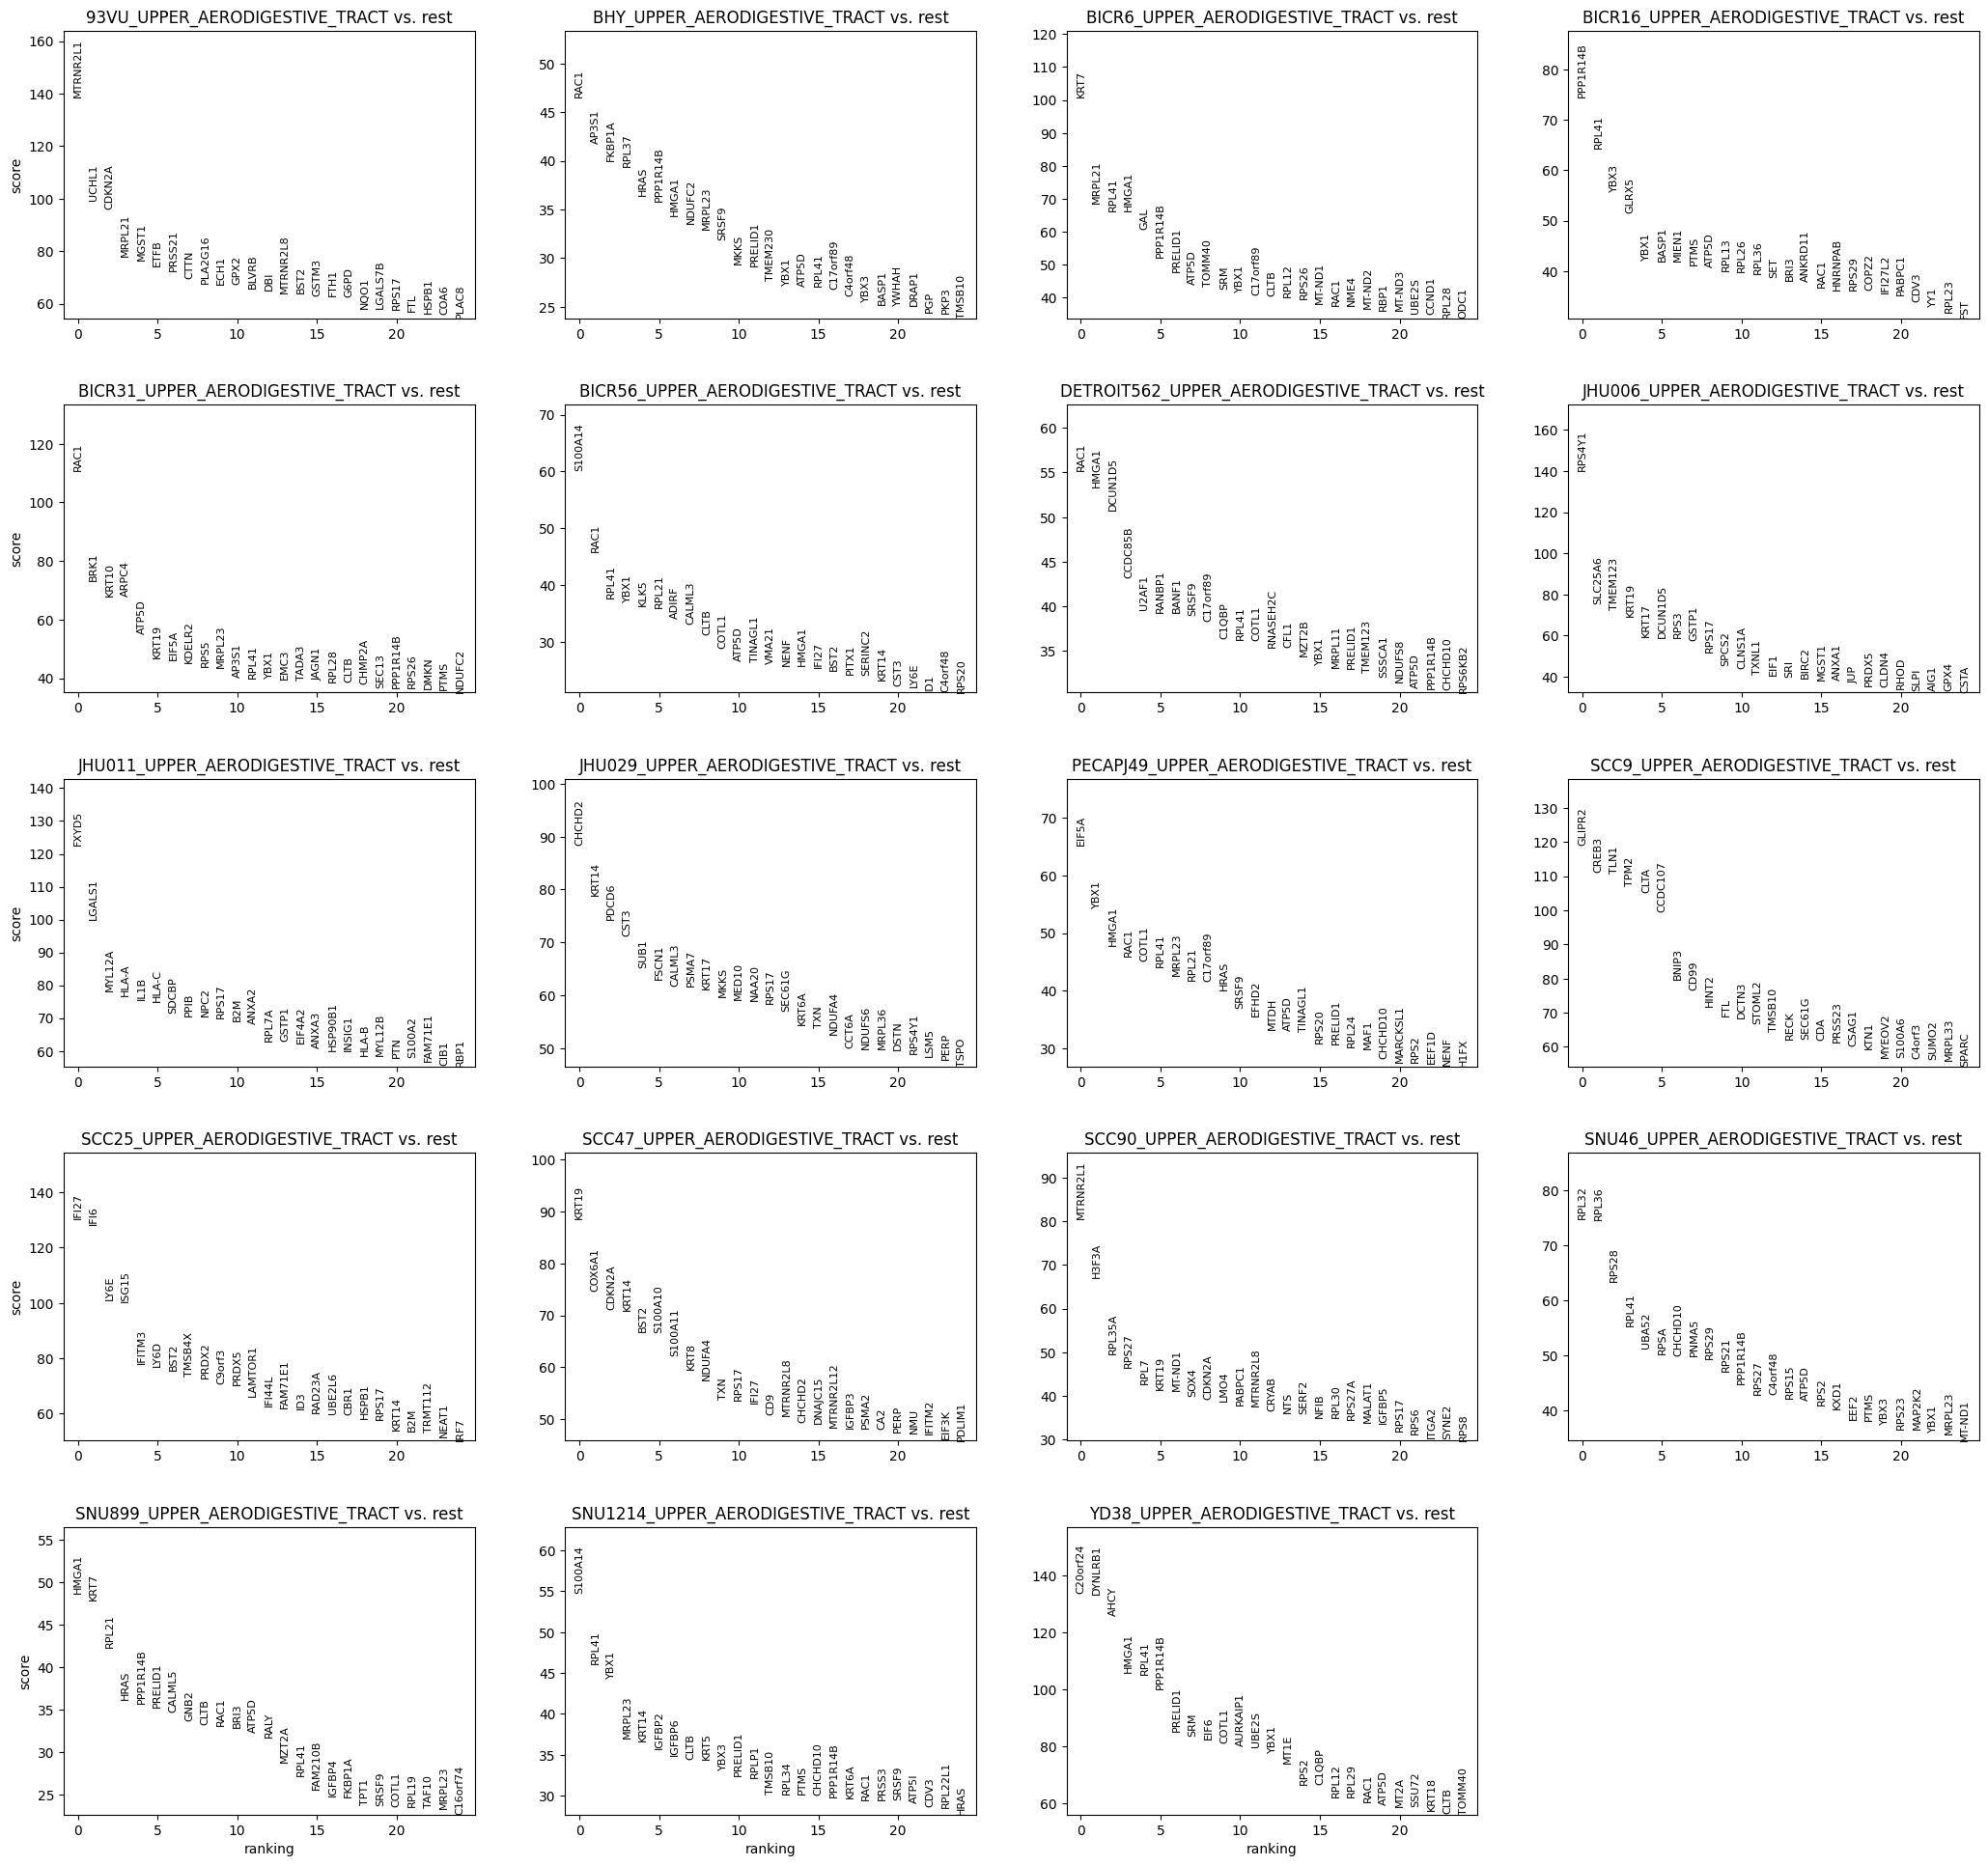

In [27]:
sc.tl.rank_genes_groups(adata_hnscc, groupby = 'CellLine', method = 't-test', key_added = 't_test')
sc.pl.rank_genes_groups(adata_hnscc, groupby = 'CellLine', n_genes = 25, sharey = False, key = 't_test')

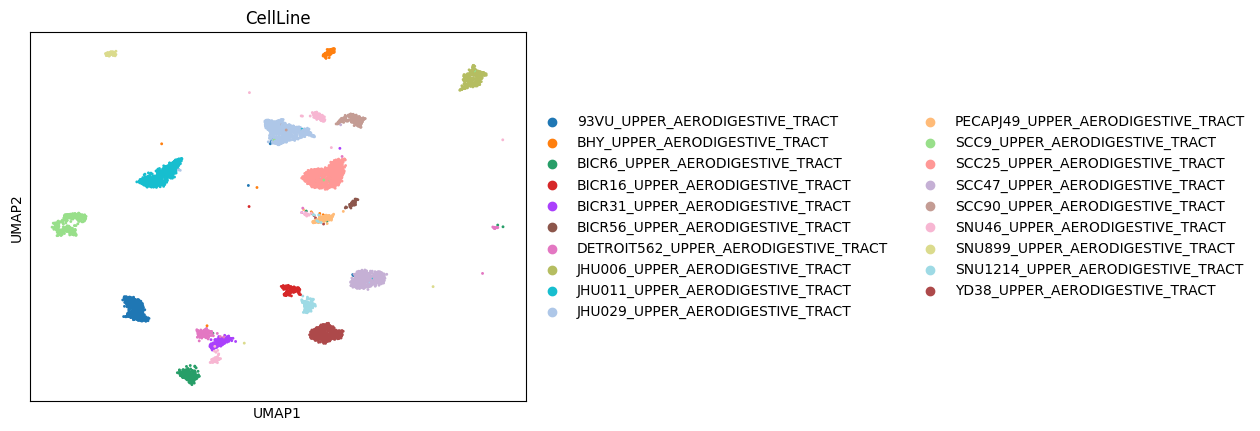

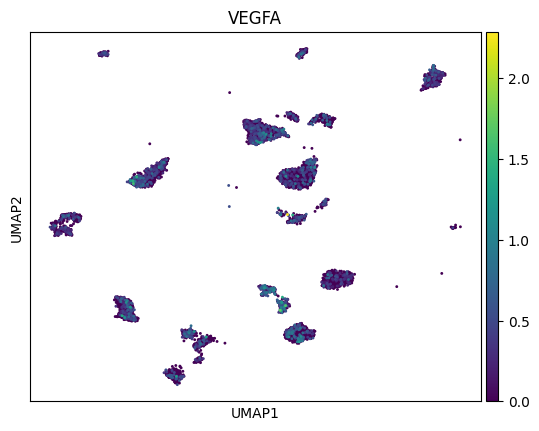

In [28]:
sc.pl.umap(adata_hnscc, color = ['CellLine'])
sc.pl.umap(adata_hnscc, color = ['VEGFA'])

In [29]:
df_hnscc_target = df_hnscc[df_hnscc['CellLine']=='SNU1214_UPPER_AERODIGESTIVE_TRACT'].copy()
df_hnscc_others = df_hnscc[df_hnscc['CellLine']!='SNU1214_UPPER_AERODIGESTIVE_TRACT'].copy()

In [30]:
t_stat, p_value = stats.ttest_ind(df_hnscc_target['VEGFA'], df_hnscc_others['VEGFA'], equal_var = False)
print(f"T statistic: {t_stat} \n P value: {p_value}")
f_stat, p_value = stats.f_oneway(df_hnscc_target['VEGFA'], df_hnscc_others['VEGFA'])
print(f"F statistic: {f_stat} \n P value: {p_value}")

T statistic: 7.257565460715087 
 P value: 9.732026231693352e-12
F statistic: 148.4034830848608 
 P value: 8.405728969806294e-34


In [31]:
tukey_result = pairwise_tukeyhsd(endog = df_hnscc['VEGFA'], groups = df_hnscc['CellLine'], alpha = 0.05)
print(tukey_result)

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


                              Multiple Comparison of Means - Tukey HSD, FWER=0.05                               
               group1                               group2                meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------------------------------
      93VU_UPPER_AERODIGESTIVE_TRACT        BHY_UPPER_AERODIGESTIVE_TRACT  -0.0079    1.0 -0.0812  0.0655  False
      93VU_UPPER_AERODIGESTIVE_TRACT     BICR16_UPPER_AERODIGESTIVE_TRACT   0.1575    0.0   0.094  0.2209   True
      93VU_UPPER_AERODIGESTIVE_TRACT     BICR31_UPPER_AERODIGESTIVE_TRACT  -0.0477 0.3367 -0.1076  0.0123  False
      93VU_UPPER_AERODIGESTIVE_TRACT     BICR56_UPPER_AERODIGESTIVE_TRACT  -0.0226    1.0 -0.1162  0.0711  False
      93VU_UPPER_AERODIGESTIVE_TRACT      BICR6_UPPER_AERODIGESTIVE_TRACT   -0.037 0.7242 -0.0942  0.0201  False
      93VU_UPPER_AERODIGESTIVE_TRACT DETROIT562_UPPER_AERODIGESTIVE_TRACT   0.1117    0.0  0.041